In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from tqdm import tqdm

from circuit_prep import (
    amplitude_damping_channel,
    convert_to_bell_basis,
    compute_estimator,
    hoeffding,
    prepare_bell_state,
    run_circuit,
)

# Setup: define the circuits and execution code

In [2]:
def circuit_1(gamma: float, k: int, l: int):
    """This is the circuit that corresponds to e^{Lt} ⊗ e^{Lt}."""
    ckt1 = QuantumCircuit(4, 2)
    prepare_bell_state(ckt1, qubit_a=0, qubit_b=2, k=k, l=l)
    ckt1.barrier()
    amplitude_damping_channel(ckt1, qubit_a=0, qubit_b=1, gamma=gamma)
    amplitude_damping_channel(ckt1, qubit_a=2, qubit_b=3, gamma=gamma)
    ckt1.barrier()
    convert_to_bell_basis(ckt1, qubit_a=0, qubit_b=2)
    ckt1.barrier()
    ckt1.measure([0, 2], [0, 1])
    return ckt1

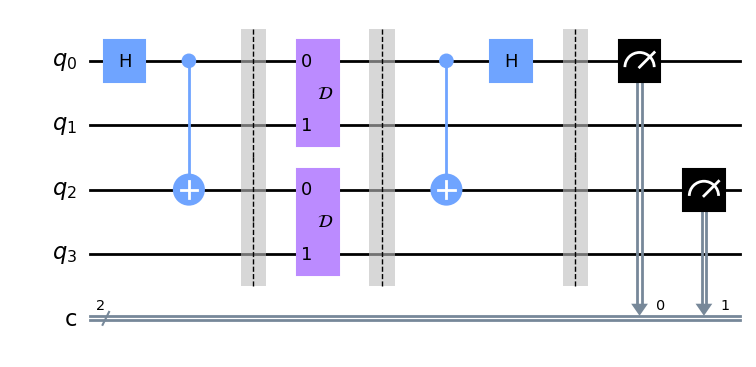

In [3]:
# Visualize an example of the non-symmetrized circuit
ckt1 = circuit_1(gamma=0.5, k=0, l=0)
ckt1.draw(output='mpl')

In [4]:
def circuit_2(gamma: float, k: int, l: int, symmetry: str):
    """
    This is the 'symmetrized' circuit, implementing (W ∘ e^{Lt}) ⊗ (e^{Lt} ∘ W),
    where {I, W} is our unitary representation of ℤ₂.
    """
    ckt2 = QuantumCircuit(4, 2)
    prepare_bell_state(ckt2, qubit_a=0, qubit_b=2, k=k, l=l)
    ckt2.barrier()

    if symmetry == 'x':
        ckt2.x(0)
    elif symmetry == 'z':
        ckt2.z(0)

    amplitude_damping_channel(ckt2, qubit_a=0, qubit_b=1, gamma=gamma)
    amplitude_damping_channel(ckt2, qubit_a=2, qubit_b=3, gamma=gamma)

    if symmetry == 'x':
        ckt2.x(2)
    elif symmetry == 'z':
        ckt2.z(2)

    ckt2.barrier()
    convert_to_bell_basis(ckt2, qubit_a=0, qubit_b=2)
    ckt2.barrier()
    ckt2.measure([0, 2], [0, 1])
    return ckt2

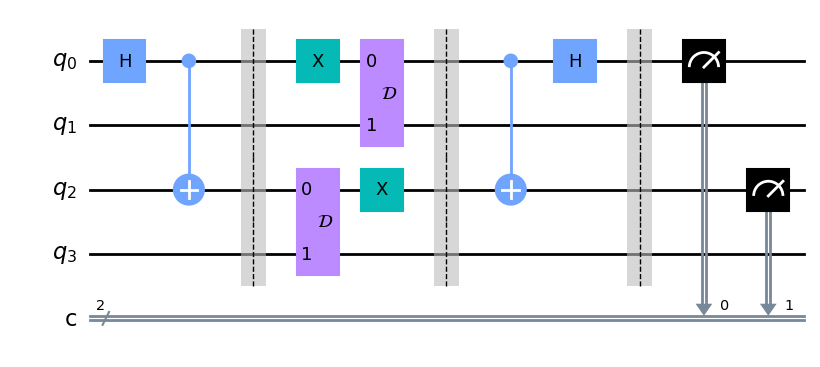

In [5]:
# Visualize an example of the symmetrized circuit
ckt2 = circuit_2(gamma=0.5, k=0, l=0, symmetry='x')
ckt2.draw(output='mpl')

In [6]:
def run_sim(gamma: float, shots: int, symmetry: str, use_noise_model=False):
    """Execute the simulation to estimate the asymmetry of the system."""
    ckt1_results = {}
    ckt2_results = {}
    for i in range(4):
        k_l = f"{i:02b}"
        k, l = [int(char) for char in k_l]

        c1 = circuit_1(gamma, k, l)
        c1_results = run_circuit(c1, shots // 4, use_noise_model)
        ckt1_results[k_l] = c1_results

        c2 = circuit_2(gamma, k, l, symmetry)
        c2_results = run_circuit(c2, shots // 4, use_noise_model)
        ckt2_results[k_l] = c2_results

    Y1 = compute_estimator(ckt1_results)
    Y2 = compute_estimator(ckt2_results)
    return Y1 - Y2

# Measure X and Z asymmetry the noiseless simulator

In [7]:
# Estimate X and Z asymmetries using the noiseless simulator
shots = hoeffding(epsilon=0.01, delta=0.01)
Gammas = np.linspace(0, 10, 50)

noiseless_x_results = []
noiseless_z_results = []

for Gamma in tqdm(Gammas):
    gamma = 1 - np.exp(-Gamma)
    noiseless_x_results.append(run_sim(gamma, shots, 'x'))
    noiseless_z_results.append(run_sim(gamma, shots, 'z'))

100%|██████████| 50/50 [00:16<00:00,  2.95it/s]


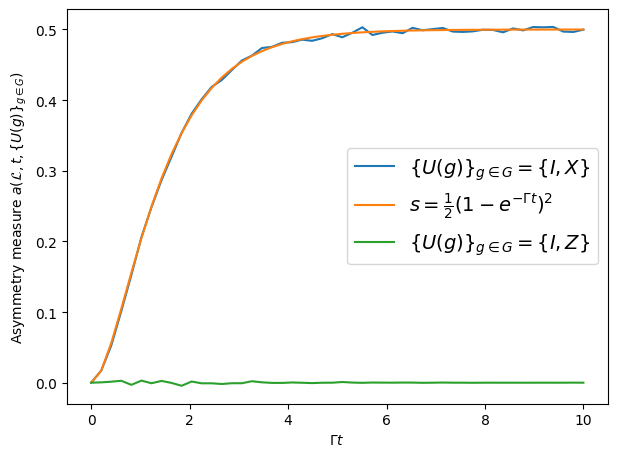

In [8]:
# Plot the noiseless simulation results and the analytical X asymmetry measure
plt.cla()
plt.rcParams.update({'font.size': 14})
plt.plot(Gammas, noiseless_x_results, label=r'$\{U(g)\}_{g\in G} = \{I, X\}$')
plt.plot(Gammas, (1-np.exp(-Gammas))**2 / 2, label=r'$s = \frac{1}{2}(1-e^{-\Gamma t})^2$')
plt.plot(Gammas, noiseless_z_results, label=r'$\{U(g)\}_{g\in G} = \{I, Z\}$')
plt.ylabel(r'Asymmetry measure $a(\mathcal{L}, t, \{U(g)\}_{g\in G} )$')
plt.xlabel(r'$\Gamma t$')
plt.legend()
plt.tight_layout()
# plt.savefig('noiseless_amp_damp.pdf', dpi=300, format="pdf")

# Measure X and Z asymmetry using the noisy simulator

In [9]:
# Estimate X and Z asymmetries using the noisy simulator
shots = hoeffding(0.01, 0.01)
Gammas = np.linspace(0, 10, 50)

noisy_x_results = []
noisy_z_results = []

for Gamma in tqdm(Gammas):
    gamma = 1 - np.exp(-Gamma)
    noisy_x_results.append(run_sim(gamma, shots, 'x', use_noise_model=True))
    noisy_z_results.append(run_sim(gamma, shots, 'z', use_noise_model=True))

100%|██████████| 50/50 [01:07<00:00,  1.34s/it]


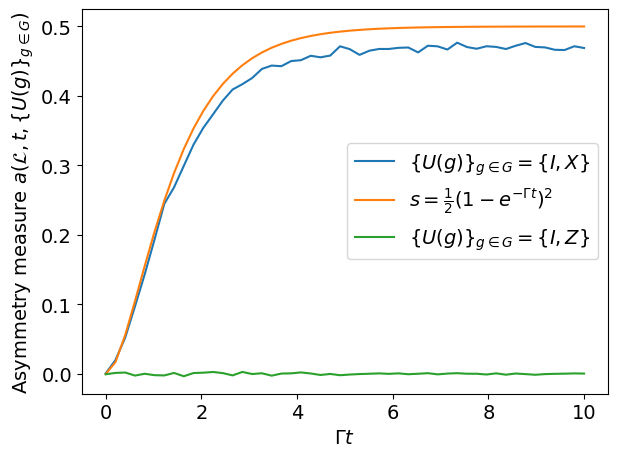

In [10]:
# Plot the noisy simulation results and the analytical X asymmetry measure
plt.cla()
plt.rcParams.update({'font.size': 14})
plt.plot(Gammas, noisy_x_results, label=r'$\{U(g)\}_{g\in G} = \{I, X\}$')
plt.plot(Gammas, (1-np.exp(-Gammas))**2 / 2, label=r'$s = \frac{1}{2}(1-e^{-\Gamma t})^2$')
plt.plot(Gammas, noisy_z_results, label=r'$\{U(g)\}_{g\in G} = \{I, Z\}$')
plt.ylabel(r'Asymmetry measure $a(\mathcal{L}, t, \{U(g)\}_{g\in G} )$')
plt.xlabel(r'$\Gamma t$')
plt.legend()
plt.tight_layout()
# plt.savefig('noisy_amp_damp.pdf', dpi=300, format="pdf")